In [1]:

!pip install -Uqqq pip --progress-bar off
!pip install -qqq torch==2.1 --progress-bar off
!pip install -qqq transformers==4.34.1 --progress-bar off
!pip install -qqq accelerate==0.23.0 --progress-bar off
!pip install -qqq bitsandbytes==0.41.1 --progress-bar off
!pip install -qqq llava-torch==1.1.1 --progress-bar off

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires kaleido, which is not installed.
tensorflow-probability 0.22.0 requires typing-extensions<4.6.0, but you have typing-extensions 4.8.0 which is incompatible.
torchaudio 2.1.0+cu118 requires torch==2.1.0, but you have torch 2.0.1 which is incompatible.
torchdata 0.7.0 requires torch==2.1.0, but you have torch 2.0.1 which is incompatible.
torchtext 0.16.0 requires torch==2.1.0, but you have torch 2.0.1 which is incompatible.


In [2]:
import textwrap
from io import BytesIO

import requests
import torch
from llava.constants import DEFAULT_IMAGE_TOKEN, IMAGE_TOKEN_INDEX
from llava.conversation import SeparatorStyle, conv_templates
from llava.mm_utils import (
    KeywordsStoppingCriteria,
    get_model_name_from_path,
    process_images,
    tokenizer_image_token,
)
from llava.model.builder import load_pretrained_model
from llava.utils import disable_torch_init
from PIL import Image

[2023-12-09 12:20:31,120] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [3]:
disable_torch_init()

In [4]:
MODEL = "4bit/llava-v1.5-13b-3GB"
model_name = get_model_name_from_path(MODEL)
model_name

'llava-v1.5-13b-3GB'

In [5]:
tokenizer, model, image_processor, context_len = load_pretrained_model(
    model_path=MODEL, model_base=None, model_name=model_name, load_4bit=True
)

Loading checkpoint shards:   0%|          | 0/9 [00:00<?, ?it/s]

In [9]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


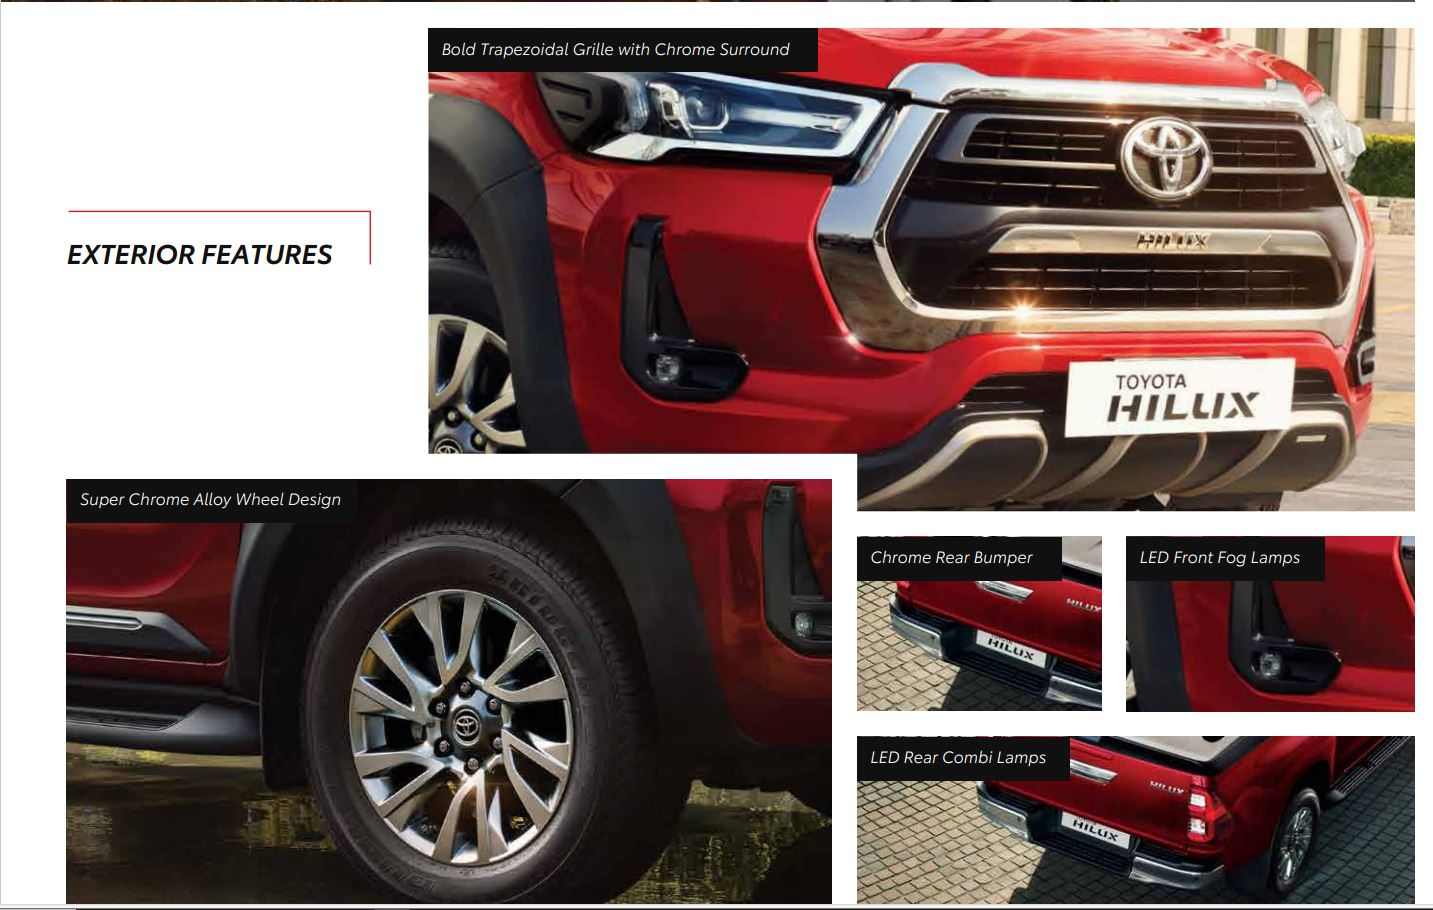

In [10]:
image = load_image('/content/drive/My Drive/hilux.JPG')
image

In [6]:
def load_image(image_file):
    if image_file.startswith("http://") or image_file.startswith("https://"):
        response = requests.get(image_file)
        image = Image.open(BytesIO(response.content)).convert("RGB")
    else:
        image = Image.open(image_file).convert("RGB")
    return image

In [11]:
def process_image(image):
    args = {"image_aspect_ratio": "pad"}
    image_tensor = process_images([image], image_processor, args)
    return image_tensor.to(model.device, dtype=torch.float16)

In [12]:
processed_image = process_image(image)
type(processed_image), processed_image.shape

(torch.Tensor, torch.Size([1, 3, 336, 336]))

In [13]:
CONV_MODE = "llava_v0"

In [14]:
def create_prompt(prompt: str):
    conv = conv_templates[CONV_MODE].copy()
    roles = conv.roles
    prompt = DEFAULT_IMAGE_TOKEN + "\n" + prompt
    conv.append_message(roles[0], prompt)
    conv.append_message(roles[1], None)
    return conv.get_prompt(), conv

In [15]:
prompt, _ = create_prompt("What is the image about")
print(prompt)

A chat between a curious human and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the human's questions.###Human: <image>
What is the image about###Assistant:


In [16]:
def image_analysis(image: Image, prompt: str):
    image_tensor = process_image(image)
    prompt, conv = create_prompt(prompt)
    input_ids = (
        tokenizer_image_token(prompt, tokenizer, IMAGE_TOKEN_INDEX, return_tensors="pt")
        .unsqueeze(0)
        .to(model.device)
    )

    stop_str = conv.sep if conv.sep_style != SeparatorStyle.TWO else conv.sep2
    stopping_criteria = KeywordsStoppingCriteria(
        keywords=[stop_str], tokenizer=tokenizer, input_ids=input_ids
    )

    with torch.inference_mode():
        output_ids = model.generate(
            input_ids,
            images=image_tensor,
            do_sample=True,
            temperature=0.01,
            max_new_tokens=512,
            use_cache=True,
            stopping_criteria=[stopping_criteria],
        )
    return tokenizer.decode(
        output_ids[0, input_ids.shape[1] :], skip_special_tokens=True
    ).strip()

In [17]:
%%time
result = image_analysis(image, "What is the image about")
print(textwrap.fill(result, width=110))

The image is a collage of various pictures featuring a red truck. The collage includes different angles and
perspectives of the truck, showcasing its design and features. The truck is prominently displayed in the
image, with its distinctive red color and chrome accents. The collage also includes a close-up view of the
truck's front end, highlighting its grille and headlights. The overall presentation of the collage emphasizes
the truck's design and aesthetics, making it an appealing visual representation of the vehicle.
CPU times: user 16.2 s, sys: 622 ms, total: 16.9 s
Wall time: 22.3 s


In [18]:
%%time
result = image_analysis(image, "What is the brand and model of the vehicle shown in the image ")
print(textwrap.fill(result, width=110))

The brand and model of the vehicle shown in the image is a Toyota HiLux.
CPU times: user 3.39 s, sys: 316 ms, total: 3.71 s
Wall time: 3.76 s


In [19]:
%%time
result = image_analysis(image, "Does the vehicle have alloy wheel ")
print(textwrap.fill(result, width=110))

Yes, the vehicle has an alloy wheel.
CPU times: user 2.47 s, sys: 323 ms, total: 2.79 s
Wall time: 2.89 s
